In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
url="https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2" \
    "Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,120,170,174,237,273,281,299,349,367,423
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,212,223,243,259,277,304,333,361,377,383
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,511,584,716,847,986,1171,1251,1320,1423,1468
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,334,370,376,390,428,439,466,501,525,545
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,7,7,8,8,8,10,14,16,17


In [4]:
countries = {"Russia", "Italy", "Japan", "Spain", "Germany", "Korea, South", "Brazil", "Iran", "US", "Singapore"}

In [5]:
df[df["Country/Region"].isin(countries)]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
28,NaN,Brazil,-14.2350,-51.9253,0,0,0,0,0,0,...,4256,4579,5717,6836,8044,9056,10360,11130,12161,14034
120,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,62095,66885,71808,77872,84794,91159,96092,100123,103374,107663
133,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,38309,41495,44605,47593,50468,53183,55743,58226,60500,62589
137,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,97689,101739,105792,110574,115242,119827,124632,128948,132547,135586
139,NaN,Japan,36.0000,138.0000,2,2,2,2,4,4,...,1866,1866,1953,2178,2495,2617,3139,3139,3654,3906
143,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,9583,9661,9786,9887,9976,10062,10156,10237,10284,10331
187,NaN,Russia,60.0000,90.0000,0,0,0,0,0,0,...,1534,1836,2337,2777,3548,4149,4731,5389,6343,7497
196,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,844,879,926,1000,1049,1114,1189,1309,1375,1481
201,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,80110,87956,95923,104118,112065,119199,126168,131646,136675,141942
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,140909,161837,188172,213372,243616,275586,308850,337072,366667,396223


In [6]:
confirmed = dict()
for country in countries:
    cdf = df[(df["Country/Region"]==country) & (df["Province/State"].isnull())][df.columns[4:-1]].T
    if len(cdf.columns) > 0:
        confirmed[country] = np.array(cdf[cdf.columns[0]])

In [7]:
cdf = df[(df["Province/State"]=="Hubei")][df.columns[4:-1]].T
confirmed["Hubei"] = np.array(cdf[cdf.columns[0]])

In [8]:
import matplotlib.pyplot as plt

In [9]:
def exp_smoothing(lst, alpha=0.1):
    tmp_ = lst[0]
    result = [tmp_]
    for x in lst[1:]:
        tmp_ =  x * (1 - alpha) + alpha * tmp_
        result.append(tmp_)
    return result

In [10]:
def division_smoothed(lst):
    result = []
    for prev, cur in zip(lst[:-1], lst[1:]):
        if prev < 1.0:
            result.append(1.0)
        else:
            result.append(cur / prev)
    return result

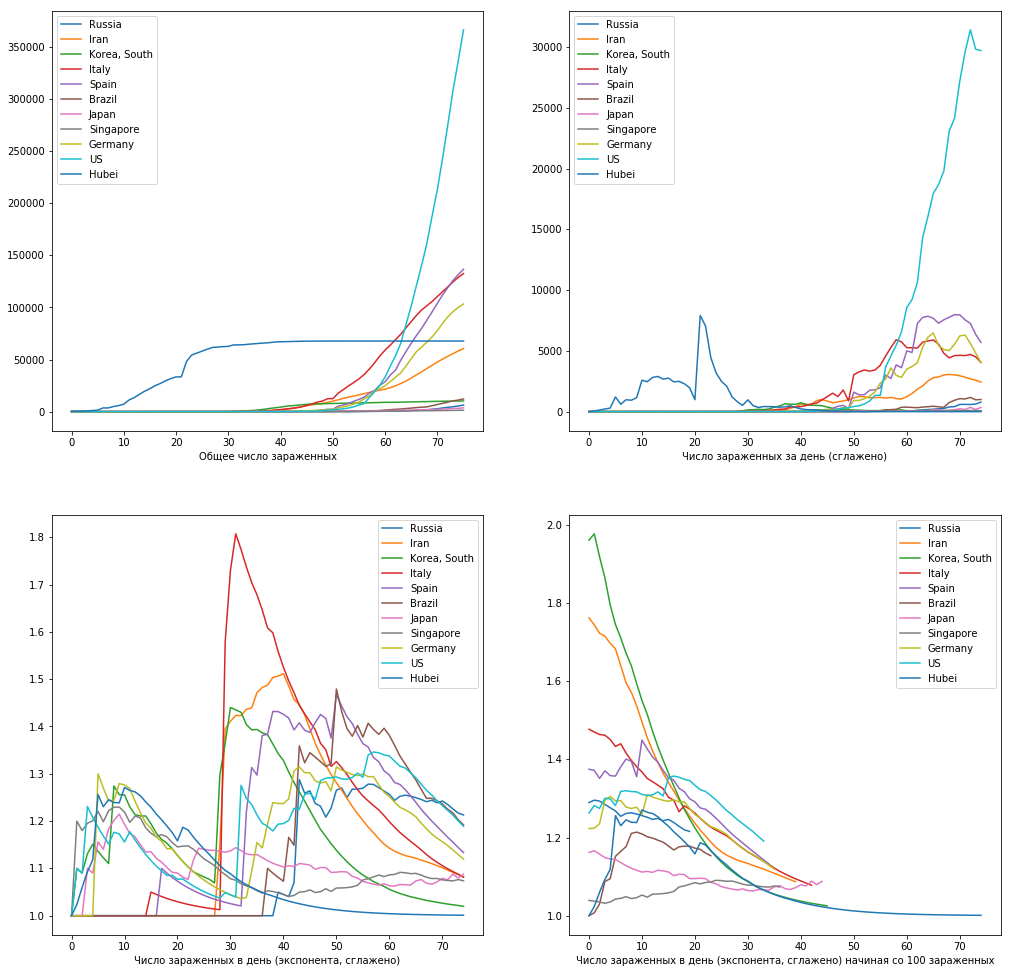

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(17, 17))
ax[0, 0].set_xlabel("Общее число зараженных")
for country, cases in confirmed.items():
    ax[0, 0].plot(range(0, len(cases)), cases, label=country)
ax[0, 0].legend()

ax[0, 1].set_xlabel("Число зараженных за день (cглажено)")
for country, cases in confirmed.items():
    ax[0, 1].plot(range(0, len(cases) - 1), exp_smoothing(cases[1:] - cases[:-1], alpha=0.5), label=country)
ax[0, 1].legend()

ax[1, 0].set_xlabel("Число зараженных в день (экспонента, сглажено)")
for country, cases in confirmed.items():
    ax[1, 0].plot(range(0, len(cases) - 1), exp_smoothing(division_smoothed(cases), alpha=0.9), label=country)
ax[1, 0].legend()

ax[1, 1].set_xlabel("Число зараженных в день (экспонента, сглажено) начиная со 100 зараженных")
for country, cases in confirmed.items():
    cases = cases[cases.searchsorted(100):]
    ax[1, 1].plot(range(0, len(cases) - 1), exp_smoothing(cases[1:] / (cases[:-1]), alpha=0.9), label=country)
ax[1, 1].legend()

fig.savefig("covid19.png")
plt.show()